# Stance Detection using SemEval2016 DataSet and LSTM Model

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

training = "H:\Project Files\stance-detection\Dataset-SemEval2016/training.txt"
test = "H:\Project Files\stance-detection\Dataset-SemEval2016/test-gold.txt"

df = pd.read_csv(training, sep='\t',header=0,encoding='utf-8')
test = pd.read_csv(test, sep='\t',header=0,encoding='utf-8')
df.info()

## Tweet Preprocessing

In [165]:
import re
import nltk
from nltk.corpus import stopwords

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['Tweet'] = df.Tweet + ' ' + df.Target
df['Tweet'] = df['Tweet'].apply(clean_text)
df['Tweet'] = df['Tweet'].str.replace('\d+', '')

test['Tweet'] = test.Tweet + ' ' + test.Target
test['Tweet'] = test['Tweet'].apply(clean_text)
test['Tweet'] = test['Tweet'].str.replace('\d+', '')

In [166]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8937 unique tokens.


In [167]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['Tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

X1 = tokenizer.texts_to_sequences(test['Tweet'].values)
X1 = pad_sequences(X1, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (2814, 250)


In [168]:
Y = pd.get_dummies(df['Stance']).values

Y1 = pd.get_dummies(test['Stance']).values

print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2814, 3)


In [169]:
from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.0, random_state = 42)
# X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1,Y1, test_size = 1.0, random_state = 42)
X_train = X
X_test=X1
Y_train=Y
Y_test=Y1
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2814, 250) (2814, 3)
(1249, 250) (1249, 3)


## LSTM Model - 1

In [170]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

print(model.summary())

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 250, 100)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None
Train on 2532 samples, validate on 282 samples
Epoch 1/5
2532/2532 [==============================] - 36s 14ms/step - loss: 1.0440 - acc: 0.4988 - val_loss: 0.9656 - val_acc: 0.5993
Epoch 2/5
2532/2532 [==============================] - 28s 11ms/step - loss: 

In [171]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1249/1249 [==============================] - 2s 2ms/step
Test set
  Loss: 1.173
  Accuracy: 0.584


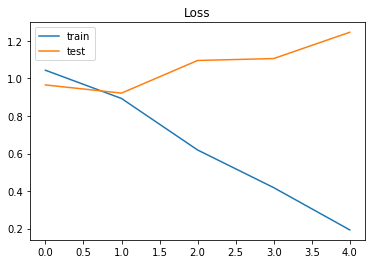

In [172]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

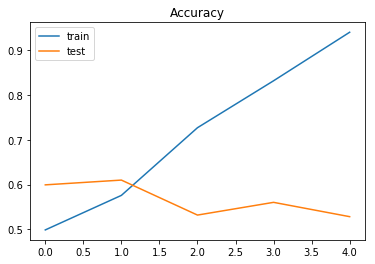

In [173]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

## CNN + LSTM Model - 2

In [175]:
from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, Bidirectional, merge, concatenate, Input, Dropout, LSTM

y_dim=3
num_filters=200
filter_sizes=[3,4,5] 
pool_padding='valid' 
dropout=0.5

embed_input = Input(shape=(X.shape[1],))
x = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(embed_input)
pooled_outputs = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='valid', activation='relu')(x)
    conv = MaxPooling1D(pool_size=EMBEDDING_DIM-filter_sizes[i]+1)(conv)           
    pooled_outputs.append(conv)
merge = concatenate(pooled_outputs)
    
x = Dense(30, activation='relu')(merge)
x = Dropout(dropout)(x)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(x)
x = Dense(30, activation='relu')(x)
x = Dropout(dropout)(x)
x = Flatten()(x)
x = Dense(y_dim, activation='sigmoid')(x)

model = Model(inputs=embed_input,outputs=x)

#   model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

epochs = 3
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 250, 100)     5000000     input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 248, 200)     60200       embedding_30[0][0]               
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 247, 200)     80200       embedding_30[0][0]               
__________________________________________________________________________________________________
conv1d_42 

In [176]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1249/1249 [==============================] - 3s 3ms/step
Test set
  Loss: 0.589
  Accuracy: 0.667


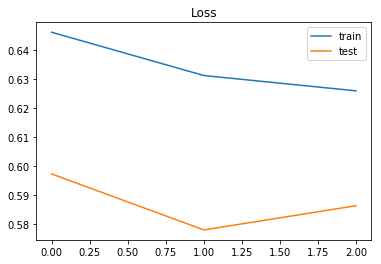

In [177]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

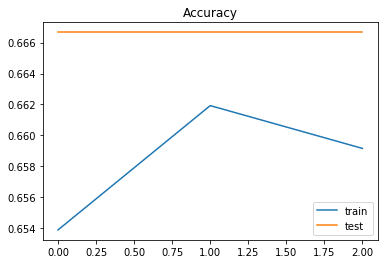

In [178]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();